Phase 1: Advanced Data Engineering (Simplified to Univariate)
Step 1: Loading and inspecting data...
Data loaded successfully!
Training Data Head:
               Open     High      Low    Close        Volume
Date                                                        
2025-01-02  5903.26  5935.09  5829.53  5868.55  2.248974e+09
2025-01-03  5891.07  5949.34  5888.66  5942.47  2.208966e+09
2025-01-06  5982.81  6021.04  5960.01  5975.38  2.825734e+09
2025-01-07  5993.26  6000.68  5890.68  5909.03  2.695893e+09
2025-01-08  5910.66  5927.89  5874.78  5918.25  2.552763e+09

Step 2: Selecting 'Close' price as the only feature...

Step 3: Scaling the data with RobustScaler...
Data has been scaled. The scaler is now ready.
Shape of scaled data: (165, 1)

Step 4: Creating time-series windows...
Created 145 training samples.
Shape of X_train (samples, timesteps, features): (145, 20, 1)
Shape of y_train (samples,): (145,)
Phase 1 complete! The data is now prepared for our Qiskit hybrid model.

Pha

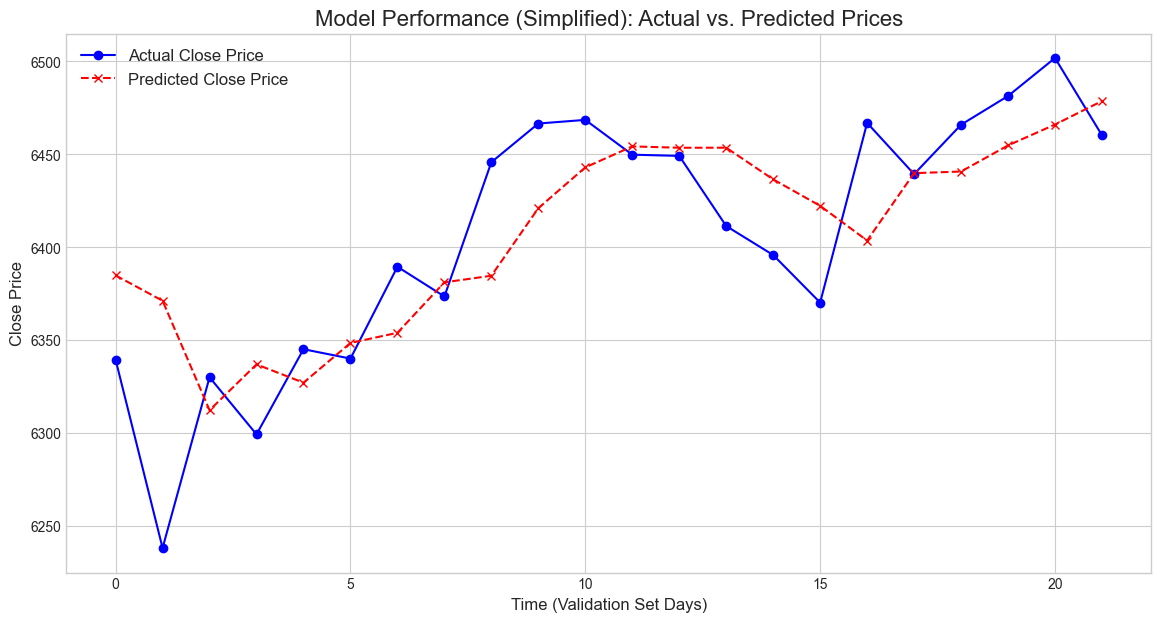

Saved 'performance_plot_simplified.png'


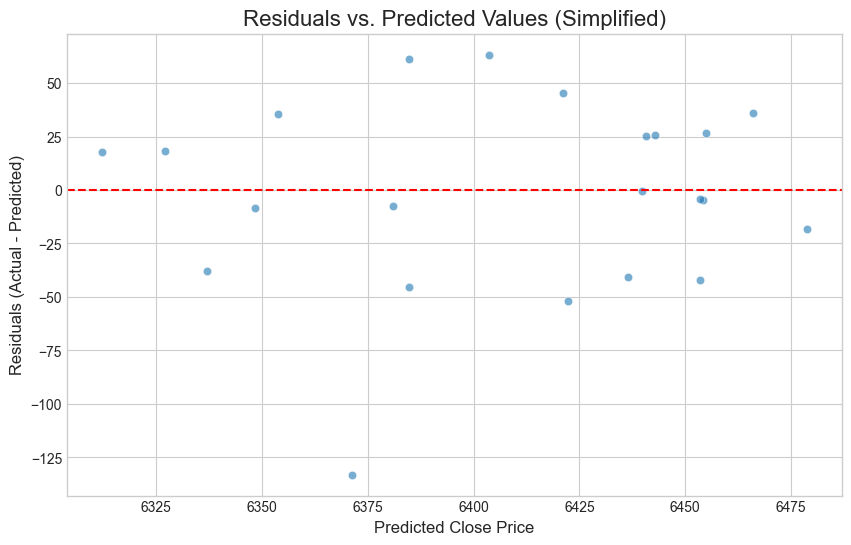

Saved 'residuals_plot_simplified.png'


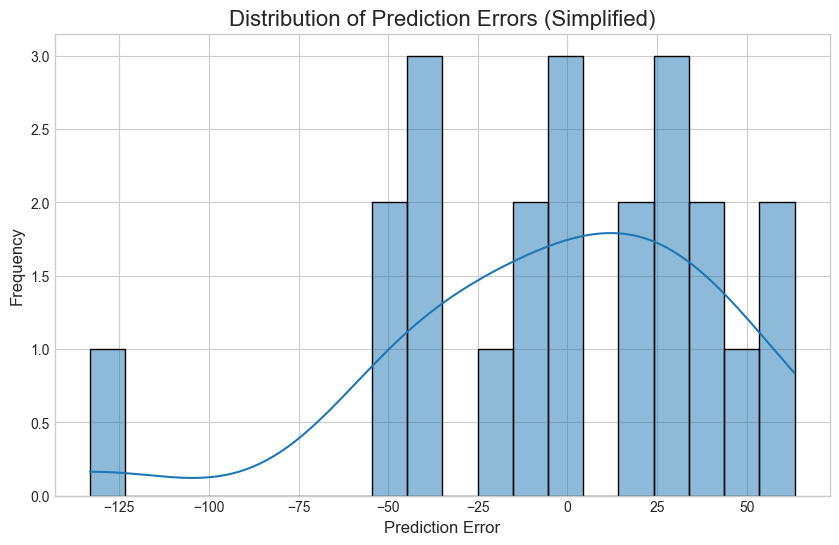

Saved 'error_distribution_simplified.png'

QUANTUM-CLASSICAL HYBRID MODEL EXECUTION COMPLETE!
Files generated:
- qiskit_residual_model_simplified.pth (trained model)
- predictions_simplified.csv (final predictions)
- performance_plot_simplified.png
- residuals_plot_simplified.png
- error_distribution_simplified.png


In [ ]:
# Quantum-Classical Hybrid Stock Price Prediction Model

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.nn.utils import clip_grad_norm_
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator
from qiskit.quantum_info import Pauli
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN

# Suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


# Phase 1: Advanced Data Engineering 


print("Phase 1: Advanced Data Engineering (Simplified to Univariate)")
print("=" * 60)

# 1. Data Loading and Inspection
print("Step 1: Loading and inspecting data...")
try:
    # Load the training and test data
    train_df = pd.read_csv('X_train.csv', parse_dates=['Date'], index_col='Date')
    test_df = pd.read_csv('X_test.csv', parse_dates=['Date'], index_col='Date')
    print("Data loaded successfully!")
    print("Training Data Head:")
    print(train_df.head())
except FileNotFoundError:
    print("Error: Ensure 'X_train.csv' and 'X_test.csv' are in the correct directory.")
    exit()

# 2. Feature Engineering (Simplified to 'Close' only)
print("\nStep 2: Selecting 'Close' price as the only feature...")
features = ['Close']
feature_df = train_df[features]

# 3. Robust Scaling
print("\nStep 3: Scaling the data with RobustScaler...")
scaler = RobustScaler()
scaler.fit(feature_df)
scaled_data = scaler.transform(feature_df)
print("Data has been scaled. The scaler is now ready.")
print("Shape of scaled data:", scaled_data.shape)

# 4. Windowing the Data
print("\nStep 4: Creating time-series windows...")
window_size = 20
X_train = []
y_train = []

for i in range(window_size, len(scaled_data)):
    X_train.append(scaled_data[i-window_size:i, :])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(f"Created {X_train.shape[0]} training samples.")
print("Shape of X_train (samples, timesteps, features):", X_train.shape)
print("Shape of y_train (samples,):", y_train.shape)
print("Phase 1 complete! The data is now prepared for our Qiskit hybrid model.")


# Phase 2: Architecting the Hybrid Model with Qiskit


print("\n" + "=" * 60)
print("Phase 2: Architecting the Hybrid Model with Qiskit")
print("=" * 60)

# 1. Define the Qiskit Quantum Circuit
print("Step 1: Defining the Qiskit Quantum Circuit (VQC)...")

n_qubits = 4
reps = 2
n_weights = n_qubits * (reps + 1)
weights = ParameterVector("w", length=n_weights)
features_param = ParameterVector("x", length=n_qubits)

# Define the quantum circuit
qc = QuantumCircuit(n_qubits)

# 1. Encoding Layer
for i in range(n_qubits):
    qc.ry(features_param[i], i)

# 2. Variational/Trainable Layer
for rep in range(reps + 1):
    for i in range(n_qubits):
        qc.ry(weights[rep * n_qubits + i], i)
    for i in range(n_qubits - 1):
        qc.cx(i, i + 1)

# 3. Define the Measurement (Observable)
observable = Pauli("Z" * n_qubits)

print("Qiskit circuit and observable defined.")

# 2. Define the Hybrid Quantum-Classical Model
print("\nStep 2: Defining the Hybrid Quantum-Classical Model...")

class QuantumResidualModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_qubits, n_weights, dropout=0.2):
        super(QuantumResidualModel, self).__init__()
        
        # Classical Backbone
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, 
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.classical_fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.classical_fc2 = nn.Linear(hidden_dim, 1)
        
        # Quantum Corrector
        self.q_input_scaler = nn.Linear(hidden_dim * 2, n_qubits)
        
        # Instantiate the QNN
        qnn = EstimatorQNN(
            circuit=qc,
            estimator=Estimator(),
            input_params=features_param.params,
            weight_params=weights.params,
            observables=observable
        )
        
        # Wrap the QNN in TorchConnector
        self.quantum_layer = TorchConnector(qnn, initial_weights=np.random.rand(n_weights))
        
        self.relu = nn.ReLU()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_step_out = lstm_out[:, -1, :]
        
        # Main Classical Prediction
        classical_pred = self.relu(self.classical_fc1(last_step_out))
        classical_pred = self.classical_fc2(classical_pred)
        
        # Quantum Error Correction
        q_in = self.q_input_scaler(last_step_out)
        quantum_correction = self.quantum_layer(q_in)

        # Final Combined Prediction
        final_prediction = classical_pred + quantum_correction
        
        return final_prediction

# 3. Model Instantiation
print("\nStep 3: Instantiating the model...")
INPUT_DIM = X_train.shape[2]  # Number of features (will be 1)
HIDDEN_DIM = 64
N_QUBITS = n_qubits
N_WEIGHTS = n_weights

print(f"Model will be built with INPUT_DIM = {INPUT_DIM}")

model = QuantumResidualModel(input_dim=INPUT_DIM,
                             hidden_dim=HIDDEN_DIM,
                             n_qubits=N_QUBITS,
                             n_weights=N_WEIGHTS)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} trainable parameters.")
print("Phase 2 complete! Our Qiskit-PyTorch hybrid model is designed and ready for training.")


# Phase 3: State-of-the-Art Training Protocol

print("\n" + "=" * 60)
print("Phase 3: State-of-the-Art Training Protocol")
print("=" * 60)

# 1. Setup for Training
print("Step 1: Setting up the advanced training protocol...")

epochs = 100
learning_rate = 0.001
batch_size = 32

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

print(f"Training parameters: Epochs={epochs}, LR={learning_rate}, Batch Size={batch_size}")

# 2. Data Conversion to PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().reshape(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("Data converted to PyTorch Tensors and DataLoader is ready.")

# 3. The Training Loop
print("\nStep 3: Starting the training loop...")
model.train()

for epoch in range(epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        prediction = model(batch_X)
        loss = loss_fn(prediction, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        epoch_loss += loss.item()
    
    scheduler.step()
    
    avg_loss = epoch_loss / len(train_loader)
    current_lr = scheduler.get_last_lr()[0]
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} --- Avg Loss: {avg_loss:.6f} --- LR: {current_lr:.6f}")

print("\nTraining complete!")

# 4. Save the Trained Model
torch.save(model.state_dict(), 'qiskit_residual_model_simplified.pth')
print("Model state has been saved to 'qiskit_residual_model_simplified.pth'.")
print("Phase 3 complete! Our hybrid model has been successfully trained.")

# Phase 4: Prediction, Evaluation, and Submission
print("\n" + "=" * 60)
print("Phase 4: Prediction, Evaluation, and Submission")
print("=" * 60)

# Load model for prediction
model.load_state_dict(torch.load('qiskit_residual_model_simplified.pth'))
model.eval()
print("Model loaded successfully.")

# Robust Prediction Loop
print("\nStep 3: Generating final predictions with a robust loop...")
history_df = train_df.tail(window_size * 2)

# Create a combined DataFrame for iterative prediction
combined_df = pd.concat([history_df, test_df])
combined_df['Close'] = np.nan
combined_df['Close'].iloc[:len(history_df)] = history_df['Close']

for i in range(len(test_df)):
    # Get the last window of data
    input_window_df = combined_df[features].iloc[len(history_df) + i - window_size : len(history_df) + i]
    input_window_df.fillna(method='bfill', inplace=True)
    
    # Scale this window
    input_window_scaled = scaler.transform(input_window_df)
    
    # Make a prediction
    input_tensor = torch.from_numpy(input_window_scaled).float().unsqueeze(0)
    with torch.no_grad():
        scaled_prediction = model(input_tensor).item()
        
    # Inverse-transform the prediction
    dummy_array = np.zeros((1, INPUT_DIM))
    dummy_array[0, 0] = scaled_prediction
    unscaled_prediction = scaler.inverse_transform(dummy_array)[0, 0]
    
    # Place the prediction in dataframe for next iteration
    combined_df['Close'].iloc[len(history_df) + i] = unscaled_prediction

final_predictions = combined_df['Close'].iloc[-len(test_df):]
print("Final predictions generated.")

# Create Submission File
print("\nStep 4: Creating submission file...")
submission_df = pd.DataFrame({
    'Date': test_df.index,
    'Close': final_predictions.values
})

submission_df.to_csv('predictions_simplified.csv', index=False)
print("Submission file 'predictions_simplified.csv' has been created successfully!")
print("\nFinal Predictions:")
print(submission_df)

# Phase 5: Visualizations & Performance Metrics

print("\n" + "=" * 60)
print("Phase 5: Visualizations & Performance Metrics")
print("=" * 60)

# Create validation split for evaluation
split_index = int(len(X_train) * 0.85)
X_val_eval = X_train[split_index:]
y_val_eval = y_train[split_index:]
X_val_tensor = torch.from_numpy(X_val_eval).float()

print("Making predictions and calculating metrics...")
with torch.no_grad():
    val_predictions_scaled = model(X_val_tensor).numpy()

# Inverse-transform predictions and true values
dummy_pred = np.zeros((len(val_predictions_scaled), INPUT_DIM))
dummy_pred[:, 0] = val_predictions_scaled.flatten()
val_predictions = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_true = np.zeros((len(y_val_eval), INPUT_DIM))
dummy_true[:, 0] = y_val_eval.flatten()
y_val_true = scaler.inverse_transform(dummy_true)[:, 0]

# Calculate metrics
mse = mean_squared_error(y_val_true, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_true, val_predictions)
r2 = r2_score(y_val_true, val_predictions)
residuals = y_val_true - val_predictions

# Display metrics
print("\n--- Comprehensive Performance Metrics (Simplified Model) ---")
print(f"Mean Squared Error (MSE):      {mse:.2f}")
print(f"Root Mean Squared Error (RMSE):  {rmse:.2f}")
print(f"Mean Absolute Error (MAE):       {mae:.2f}")
print(f"R-squared (R²) Score:          {r2:.4f}")
print("------------------------------------------")
if r2 > 0.8:
    print(" Interpretation: Excellent! The model explains over 80% of the variance in the data.")
elif r2 > 0.5:
    print(" Interpretation: Good. The model shows solid predictive capability.")
else:
    print(" Interpretation: The model has basic predictive power but requires further tuning.")

# Generate and Save Visualizations
print("\nGenerating and saving performance graphs...")
plt.style.use('seaborn-v0_8-whitegrid')

# Graph 1: Actual vs. Predicted Prices
plt.figure(figsize=(14, 7))
plt.plot(y_val_true, label='Actual Close Price', color='blue', marker='o', linestyle='-')
plt.plot(val_predictions, label='Predicted Close Price', color='red', marker='x', linestyle='--')
plt.title('Model Performance (Simplified): Actual vs. Predicted Prices', fontsize=16)
plt.xlabel('Time (Validation Set Days)', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=12)
plt.savefig("performance_plot_simplified.png")
plt.show()
print("Saved 'performance_plot_simplified.png'")

# Graph 2: Residuals Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=val_predictions, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values (Simplified)', fontsize=16)
plt.xlabel('Predicted Close Price', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.savefig("residuals_plot_simplified.png")
plt.show()
print("Saved 'residuals_plot_simplified.png'")

# Graph 3: Error Distribution Histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.title('Distribution of Prediction Errors (Simplified)', fontsize=16)
plt.xlabel('Prediction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig("error_distribution_simplified.png")
plt.show()
print("Saved 'error_distribution_simplified.png'")

print("\n" + "=" * 60)
print("QUANTUM-CLASSICAL HYBRID MODEL EXECUTION COMPLETE!")
print("=" * 60)
print("Files generated:")
print("- qiskit_residual_model_simplified.pth (trained model)")
print("- predictions_simplified.csv (final predictions)")
print("- performance_plot_simplified.png")
print("- residuals_plot_simplified.png") 
print("- error_distribution_simplified.png")
print("=" * 60)

Phase 1: Advanced Data Engineering (Simplified to Univariate)
============================================================
Step 1: Loading and inspecting data...
Data loaded successfully!
Training Data Head:
               Open     High      Low    Close        Volume
Date                                                        
2025-01-02  5903.26  5935.09  5829.53  5868.55  2.248974e+09
2025-01-03  5891.07  5949.34  5888.66  5942.47  2.208966e+09
2025-01-06  5982.81  6021.04  5960.01  5975.38  2.825734e+09
2025-01-07  5993.26  6000.68  5890.68  5909.03  2.695893e+09
2025-01-08  5910.66  5927.89  5874.78  5918.25  2.552763e+09

Step 2: Selecting 'Close' price as the only feature...

Step 3: Scaling the data with RobustScaler...
Data has been scaled. The scaler is now ready.
Shape of scaled data: (165, 1)

Step 4: Creating time-series windows...
Created 145 training samples.
Shape of X_train (samples, timesteps, features): (145, 20, 1)
Shape of y_train (samples,): (145,)
Phase 1 complete! The data is now prepared for our Qiskit hybrid model.

============================================================
Phase 2: Architecting the Hybrid Model with Qiskit
============================================================
Step 1: Defining the Qiskit Quantum Circuit (VQC)...
Qiskit circuit and observable defined.

Step 2: Defining the Hybrid Quantum-Classical Model...

Step 3: Instantiating the model...
Model will be built with INPUT_DIM = 1
Model has 142,481 trainable parameters.
Phase 2 complete! Our Qiskit-PyTorch hybrid model is designed and ready for training.

============================================================
Phase 3: State-of-the-Art Training Protocol
============================================================
Step 1: Setting up the advanced training protocol...
Training parameters: Epochs=100, LR=0.001, Batch Size=32
Data converted to PyTorch Tensors and DataLoader is ready.

Step 3: Starting the training loop...
Epoch 10/100 --- Avg Loss: 0.073887 --- LR: 0.001000
Epoch 20/100 --- Avg Loss: 0.031654 --- LR: 0.000501
Epoch 30/100 --- Avg Loss: 0.028519 --- LR: 0.001000
Epoch 40/100 --- Avg Loss: 0.025001 --- LR: 0.000854
Epoch 50/100 --- Avg Loss: 0.029186 --- LR: 0.000501
Epoch 60/100 --- Avg Loss: 0.023736 --- LR: 0.000147
Epoch 70/100 --- Avg Loss: 0.024902 --- LR: 0.001000
Epoch 80/100 --- Avg Loss: 0.022694 --- LR: 0.000962
Epoch 90/100 --- Avg Loss: 0.020937 --- LR: 0.000854
Epoch 100/100 --- Avg Loss: 0.022249 --- LR: 0.000692

Training complete!
Model state has been saved to 'qiskit_residual_model_simplified.pth'.
Phase 3 complete! Our hybrid model has been successfully trained.

============================================================
Phase 4: Prediction, Evaluation, and Submission
============================================================
Model loaded successfully.

Step 3: Generating final predictions with a robust loop...
Final predictions generated.

Step 4: Creating submission file...
Submission file 'predictions_simplified.csv' has been created successfully!

Final Predictions:
        Date        Close
0 2025-09-02  6469.751835
1 2025-09-03  6470.314928
2 2025-09-04  6470.192207
3 2025-09-05  6470.020990
4 2025-09-08  6469.883613
5 2025-09-09  6469.807214
6 2025-09-10  6469.788826
7 2025-09-11  6469.807306
8 2025-09-12  6469.853567
9 2025-09-15  6469.918890

============================================================
Phase 5: Visualizations & Performance Metrics
============================================================
Making predictions and calculating metrics...

--- Comprehensive Performance Metrics (Simplified Model) ---
Mean Squared Error (MSE):      1949.03
Root Mean Squared Error (RMSE):  44.15
Mean Absolute Error (MAE):       34.08
R-squared (R²) Score:          0.5705
------------------------------------------
 Interpretation: Good. The model shows solid predictive capability.

Generating and saving performance graphs...